<a href="https://colab.research.google.com/github/kplbhatt85/Gesture_Recognition/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gesture Recognition**

**Data Reading/Data Understanding**:

In [ ]:
# Importing the necessary libraries

import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import imageio
import datetime
import abc
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

- Setting the random seed so that the results don't vary drastically:

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/val.csv').readlines())

In [473]:
# function to plot the training/validation accuracies/losses.
def plot(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(history.history['loss'])   
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(history.history['categorical_accuracy'])   
    ax[1].plot(history.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")

    ax[0].grid(color='gray', linestyle='dashed')
    ax[1].grid(color='gray', linestyle='dashed')

    plt.show()

In [ ]:
project_folder='Gesture_Recognition'

### Criteria can use for select batch/image size :
- 2GB graphics card: batch size = 16, 8 img_size = 64x64
- 4GB graphics card: batch size = 16, 8 img_size = 64x64, 128x128
- 6GB graphics card: batch size = 32, 16, 8 img_size = 64x64, 128x128
- 8GB graphics card: batch size = 128, 64, 32, 16, 8 img_size = 64x64, 128x128

## **Generator:**
- In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with img_idx, y,z and normalization such that we get high accuracy.

In [ ]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 16

In [ ]:
# Function for normalize image
def normalize_image(img):
    normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_image

In [ ]:
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:160]
    resized_image = cv2.resize(img, (y,z))
    return resized_image

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] # List of image numbers want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # Calculate the number of batches
        for batch in range(num_batches): # We iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Normalizing the images
                    image_resized=crop_resize_img(image) 
                    #image_resized = (image - np.min(image))/(np.max(image)- np.min(image))        
                    
                    # Croping and Resizing images. 
                    # Note that the images are of 2 different shape and the conv3D will throw error if the inputs in a batch have different shapes  
                    batch_data[folder,idx,:,:,0] = normalize_image(image_resized[:, : , 0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize_image(image_resized[:, : , 1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize_image(image_resized[:, : , 2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # Yield the batch_data and the batch_labels

        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    # Normalizing the images
                    image_resized=crop_resize_img(image) 
                    #image_resized = (image - np.min(image))/(np.max(image)- np.min(image))        
                    
                    # Croping and Resizing images. 
                    # Note that the images are of 2 different shape and the conv3D will throw error if the inputs in a batch have different shapes  
                    batch_data[folder,idx,:,:,0] = normalize_image(image_resized[:, : , 0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize_image(image_resized[:, : , 1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize_image(image_resized[:, : , 2])#normalise and feed in the image
                                      
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Project_data/train/'
val_path = '/content/gdrive/MyDrive/Project_data/val/'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [ ]:
# Check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# Validating batch sample
sample_val_generator = generator(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /content/gdrive/MyDrive/Project_data/train/ ; batch size = 16
(16, 30, 120, 120, 3)
Source path =  /content/gdrive/MyDrive/Project_data/val/ ; batch size = 16
(16, 30, 120, 120, 3)


# **Model Building:**

Using **Conv3D** and **MaxPooling3D** for a 3D convolution model. Also using **softmax** as last layer. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras

In [ ]:
# Creating Base Model

model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(30,120,120,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten Layers
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Softmax layer
model.add(Dense(5, activation='softmax'))

In [ ]:
# Compliling the model and summarization 
optimiser = tf.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_102 (Conv3D)         (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_117 (Ba  (None, 30, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 activation_75 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_101 (MaxPooli  (None, 15, 60, 60, 8)    0         
 ng3D)                                                           
                                                                 
 conv3d_103 (Conv3D)         (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_118 (Ba  (None, 15, 60, 60, 16) 

Creating `train_generator` and `val_generator` which will be used in `.fit_generator`:

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

- Model Callbacks Setup:

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, mode='auto', patience=4)
        
callbacks_list = [checkpoint, LR]

- `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make:

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

**Model fitting:** Will start training the model and with the help of the checkpoints,will be able to save the model at the end of each epoch.

In [ ]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train/ ; batch size = 16
Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 3.5863 - categorical_accuracy: 0.3077Source path =  /content/gdrive/MyDrive/Project_data/val/ ; batch size = 16
Batch:  7 Index: 16

Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-3.58629-0.30769-1.57032-0.21000.h5
42/42 [==============================] - 87s 2s/step - loss: 3.5863 - categorical_accuracy: 0.3077 - val_loss: 1.5703 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 1.4216 - categorical_accuracy: 0.3844
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-1.42165-0.38435-1.73935-0.25000.h5
42/42 [==============================] - 35s 853ms/step - loss: 1.4216 - categorical_accuracy: 0.3844 - val_loss: 1.7394 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
42/42 [==============================] - ETA: 0s - l

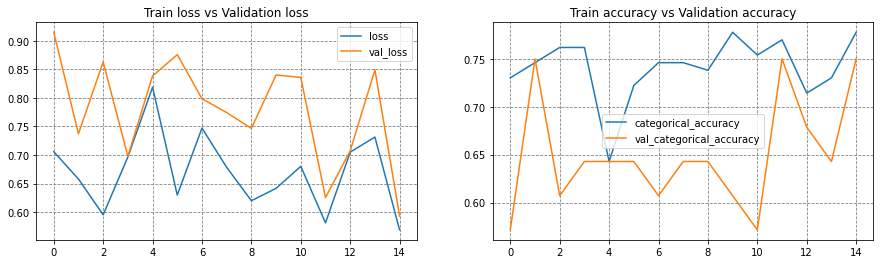

In [474]:
plot(model_history)

- **Testing various scenario like change with Image resolution, number of frames to use and batch_size:**

In [ ]:
# Model 1

batch_size = 32

model1 = Sequential()

model1.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(30,120,120,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(32, kernel_size=(2,2,2), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(64, kernel_size=(2,2,2), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten Layers
model1.add(Flatten())

model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.25))

# Softmax layer
model1.add(Dense(5, activation='softmax'))

In [ ]:
# Compliling the model and summarization 
optimiser = tf.optimizers.Adam(lr=0.001)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_110 (Conv3D)         (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_125 (Ba  (None, 30, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 activation_83 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_109 (MaxPooli  (None, 15, 60, 60, 8)    0         
 ng3D)                                                           
                                                                 
 conv3d_111 (Conv3D)         (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_126 (Ba  (None, 15, 60, 60, 16) 

In [ ]:
model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 5.8802 - categorical_accuracy: 0.2619
Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-5.88018-0.26190-1.56363-0.32143.h5
42/42 [==============================] - 19s 441ms/step - loss: 5.8802 - categorical_accuracy: 0.2619 - val_loss: 1.5636 - val_categorical_accuracy: 0.3214 - lr: 0.0010
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 2.3099 - categorical_accuracy: 0.2857
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-2.30991-0.28571-1.90498-0.17857.h5
42/42 [==============================] - 18s 446ms/step - loss: 2.3099 - categorical_accuracy: 0.2857 - val_loss: 1.9050 - val_categorical_accuracy: 0.1786 - lr: 0.0010
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 1.5098 - categorical_accuracy: 0.3651
Epoch 3: saving model to model_init_2022-08-2020_53_34.382864/model-00003-1.50980-0.36508-2.09889-0.25000.h5
42/42 [==========

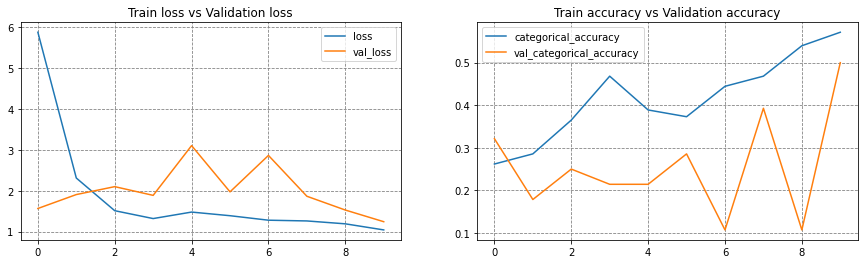

In [475]:
plot(model1_history)

##### With above observations, we can see that batch size is impacting training time but not number of frames. Tried with batch size of 8, 16 and 32 as it seems optimal (Throwing `ResourceExhaustedError` while using `batch_size = 32` or `frames > 30`). It is commented as it takes a lot of time to run that is restricting for the notebook to completely run.

In [ ]:
# Model 2

batch_size = 32

model2 = Sequential()

# model2.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(30,120,120,3), padding='same'))
# model2.add(BatchNormalization())
# model2.add(Activation('relu'))
# model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(30,120,120,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(32, kernel_size=(2,2,2), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(64, kernel_size=(2,2,2), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(128, kernel_size=(2,2,2), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten Layers
model2.add(Flatten())

model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))

# Softmax layer
model2.add(Dense(5, activation='softmax'))


In [ ]:
# Compliling the model and summarization 
optimiser = tf.optimizers.Adam(lr=0.001)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_119 (Conv3D)         (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization_134 (Ba  (None, 30, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 activation_92 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_118 (MaxPooli  (None, 15, 60, 60, 16)   0         
 ng3D)                                                           
                                                                 
 conv3d_120 (Conv3D)         (None, 15, 60, 60, 32)    4128      
                                                                 
 batch_normalization_135 (Ba  (None, 15, 60, 60, 32) 

In [ ]:
model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 11.4169 - categorical_accuracy: 0.1825
Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-11.41687-0.18254-1.64786-0.17857.h5
42/42 [==============================] - 19s 440ms/step - loss: 11.4169 - categorical_accuracy: 0.1825 - val_loss: 1.6479 - val_categorical_accuracy: 0.1786 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 1.8981 - categorical_accuracy: 0.2460
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-1.89809-0.24603-1.59483-0.14286.h5
42/42 [==============================] - 18s 449ms/step - loss: 1.8981 - categorical_accuracy: 0.2460 - val_loss: 1.5948 - val_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 1.5793 - categorical_accuracy: 0.2937
Epoch 3: saving model to model_init_2022-08-2020_53_34.382864/model-00003-1.57934-0.29365-1.64116-0.17857.h5
42/42 [=======

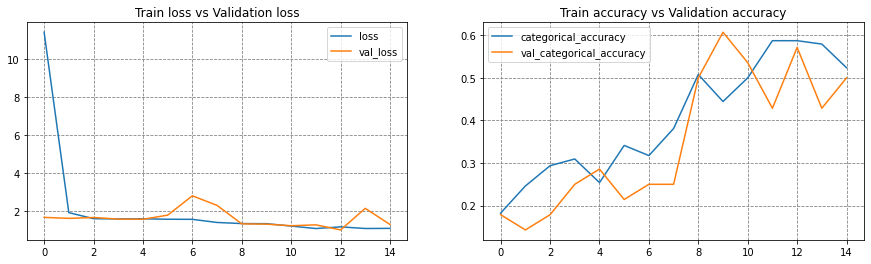

In [476]:
plot(model2_history)

In [ ]:
# Model 3

model3 = Sequential()

model3.add(Conv3D(16, kernel_size=(3,3,3), padding='same', input_shape=(30,120,120,3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
        
model3.add(Conv3D(16, kernel_size=(3,3,3), padding='same', input_shape=(30,120,120,3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
        
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
        
model3.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
        
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
        
model3.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
        
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
        
model3.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
        
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))        

model3.add(Flatten())
model3.add(Dense(1024,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(512,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(5,activation='softmax'))

In [477]:
# Compliling the model and summarization 
optimiser = tf.optimizers.Adam(lr=0.002)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_123 (Conv3D)         (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_96 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_138 (Ba  (None, 30, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_124 (Conv3D)         (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_97 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_139 (Ba  (None, 30, 120, 120, 16)  64       
 tchNormalization)                                   

In [ ]:
model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 2.9376 - categorical_accuracy: 0.1984
Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-2.93759-0.19841-102.10352-0.14286.h5
42/42 [==============================] - 21s 458ms/step - loss: 2.9376 - categorical_accuracy: 0.1984 - val_loss: 102.1035 - val_categorical_accuracy: 0.1429 - lr: 0.0020
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 2.6138 - categorical_accuracy: 0.2143
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-2.61384-0.21429-14.88250-0.32143.h5
42/42 [==============================] - 20s 484ms/step - loss: 2.6138 - categorical_accuracy: 0.2143 - val_loss: 14.8825 - val_categorical_accuracy: 0.3214 - lr: 0.0020
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 2.3190 - categorical_accuracy: 0.2857
Epoch 3: saving model to model_init_2022-08-2020_53_34.382864/model-00003-2.31901-0.28571-15.85233-0.25000.h5
42/42 [===

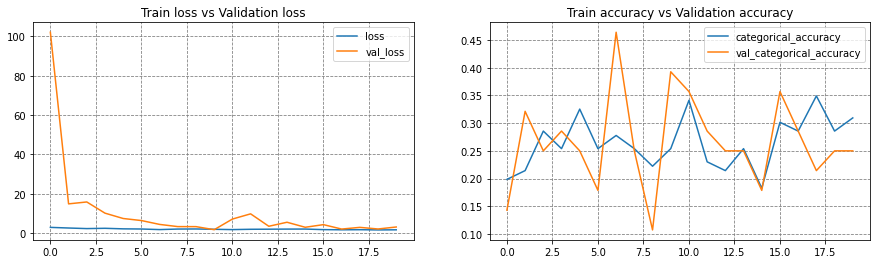

In [478]:
plot(model3_history)

- Changing Optimizer to Adadelta Experiment

In [ ]:
model3.compile(optimizer=tf.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model3.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_102 (Conv3D)         (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_117 (Ba  (None, 30, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 activation_75 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_101 (MaxPooli  (None, 15, 60, 60, 8)    0         
 ng3D)                                                           
                                                                 
 conv3d_103 (Conv3D)         (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_118 (Ba  (None, 15, 60, 60, 16) 

In [ ]:
model3_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 0.7059 - categorical_accuracy: 0.7302
Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-0.70586-0.73016-0.91515-0.57143.h5
42/42 [==============================] - 19s 441ms/step - loss: 0.7059 - categorical_accuracy: 0.7302 - val_loss: 0.9152 - val_categorical_accuracy: 0.5714 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 0.6580 - categorical_accuracy: 0.7460
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-0.65799-0.74603-0.73712-0.75000.h5
42/42 [==============================] - 18s 441ms/step - loss: 0.6580 - categorical_accuracy: 0.7460 - val_loss: 0.7371 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 0.5952 - categorical_accuracy: 0.7619
Epoch 3: saving model to model_init_2022-08-2020_53_34.382864/model-00003-0.59522-0.76190-0.86316-0.60714.h5
42/42 [==========

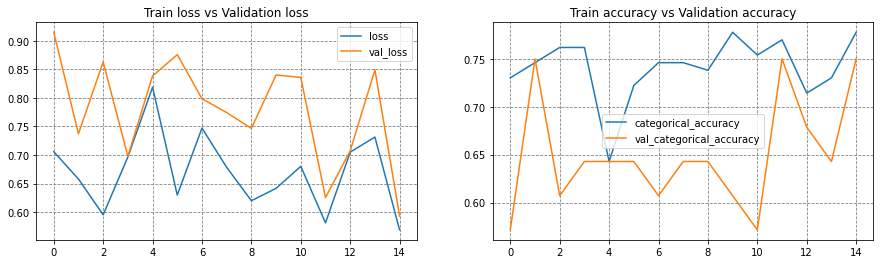

In [479]:
plot(model3_history)

In [ ]:
# Model 5:

model5 = Sequential()
batch_size = 32

model5.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(30,125,125,3), padding="same"))
model5.add(Activation('relu'))
model5.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model5.add(Dropout(0.25))

model5.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model5.add(Activation('relu'))
model5.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model5.add(Dropout(0.25))

model5.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model5.add(Activation('relu'))
model5.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model5.add(Dropout(0.25))

model5.add(Flatten())
model5.add(Dense(1024, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))

model5.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.optimizers.Adam(lr=0.001)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_149 (Conv3D)         (None, 30, 125, 125, 32)  2624      
                                                                 
 activation_122 (Activation)  (None, 30, 125, 125, 32)  0        
                                                                 
 conv3d_150 (Conv3D)         (None, 30, 125, 125, 32)  27680     
                                                                 
 activation_123 (Activation)  (None, 30, 125, 125, 32)  0        
                                                                 
 max_pooling3d_135 (MaxPooli  (None, 10, 42, 42, 32)   0         
 ng3D)                                                           
                                                                 
 dropout_80 (Dropout)        (None, 10, 42, 42, 32)    0         
                                                     

In [ ]:
model5_history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 2.1233 - categorical_accuracy: 0.2857
Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-2.12331-0.28571-21.43882-0.17857.h5
42/42 [==============================] - 21s 467ms/step - loss: 2.1233 - categorical_accuracy: 0.2857 - val_loss: 21.4388 - val_categorical_accuracy: 0.1786 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 2.2470 - categorical_accuracy: 0.3016
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-2.24702-0.30159-27.57814-0.25000.h5
42/42 [==============================] - 18s 443ms/step - loss: 2.2470 - categorical_accuracy: 0.3016 - val_loss: 27.5781 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 2.2571 - categorical_accuracy: 0.3095
Epoch 3: saving model to model_init_2022-08-2020_53_34.382864/model-00003-2.25713-0.30952-7.09887-0.32143.h5
42/42 [======

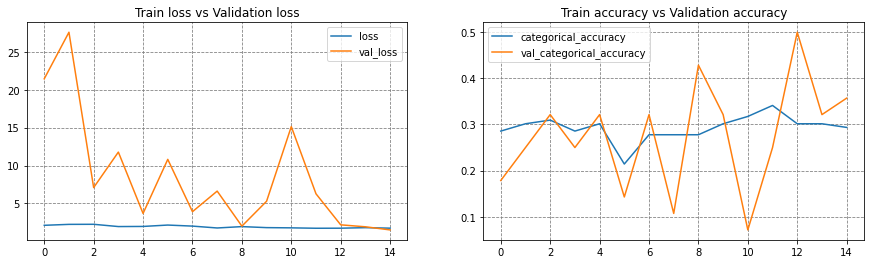

In [480]:
plot(model5_history)

In [ ]:
# Creating Base model6

batch_size = 16

model6 = Sequential()

model6.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(30,120,120,3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))

model6.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))

model6.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))

model6.add(Conv3D(64, kernel_size=(2,2,2), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten Layers
model6.add(Flatten())

model6.add(Dense(1024, activation='relu'))
model6.add(Dropout(0.5))

model6.add(Dense(1024, activation='relu'))
model6.add(Dropout(0.25))

# Softmax layer
model6.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.optimizers.Adam(lr=0.001)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_159 (Conv3D)         (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_156 (Ba  (None, 30, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 activation_132 (Activation)  (None, 30, 120, 120, 8)  0         
                                                                 
 max_pooling3d_142 (MaxPooli  (None, 15, 60, 60, 8)    0         
 ng3D)                                                           
                                                                 
 conv3d_160 (Conv3D)         (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_157 (Ba  (None, 15, 60, 60, 16) 

In [ ]:
model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 6.8554 - categorical_accuracy: 0.1667
Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-6.85541-0.16667-2.19315-0.10714.h5
42/42 [==============================] - 19s 451ms/step - loss: 6.8554 - categorical_accuracy: 0.1667 - val_loss: 2.1931 - val_categorical_accuracy: 0.1071 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 2.0213 - categorical_accuracy: 0.3095
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-2.02127-0.30952-1.58990-0.28571.h5
42/42 [==============================] - 18s 433ms/step - loss: 2.0213 - categorical_accuracy: 0.3095 - val_loss: 1.5899 - val_categorical_accuracy: 0.2857 - lr: 0.0010
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 1.6439 - categorical_accuracy: 0.3016
Epoch 3: saving model to model_init_2022-08-2020_53_34.382864/model-00003-1.64393-0.30159-1.59202-0.21429.h5
42/42 [==========

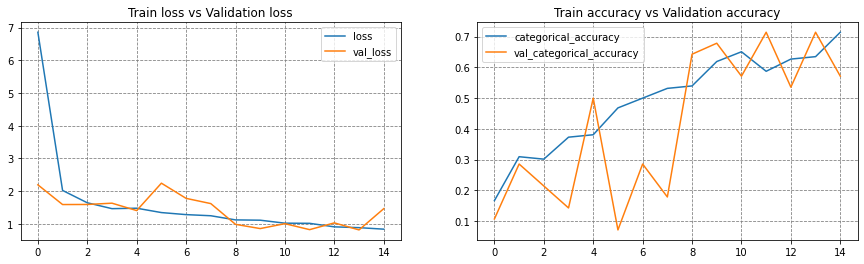

In [481]:
plot(model6_history)

In [ ]:
# Model 7

batch_size = 16

model7 = Sequential()

model7.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(30,120,120,3), padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2,2,2)))

model7.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2,2,2)))

model7.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2,2,2)))

model7.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten Layers
model7.add(Flatten())

model7.add(Dense(1024, activation='relu'))
model7.add(Dropout(0.5))

model7.add(Dense(512, activation='relu'))
model7.add(Dropout(0.25))

# Softmax layer
model7.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.optimizers.Adam(lr=0.001)
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_163 (Conv3D)         (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_160 (Ba  (None, 30, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 activation_136 (Activation)  (None, 30, 120, 120, 8)  0         
                                                                 
 max_pooling3d_146 (MaxPooli  (None, 15, 60, 60, 8)    0         
 ng3D)                                                           
                                                                 
 conv3d_164 (Conv3D)         (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_161 (Ba  (None, 15, 60, 60, 16) 

In [ ]:
model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 6.7695 - categorical_accuracy: 0.2619
Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-6.76947-0.26190-1.96528-0.17857.h5
42/42 [==============================] - 19s 448ms/step - loss: 6.7695 - categorical_accuracy: 0.2619 - val_loss: 1.9653 - val_categorical_accuracy: 0.1786 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.7478 - categorical_accuracy: 0.2698
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-1.74783-0.26984-1.53711-0.32143.h5
42/42 [==============================] - 19s 450ms/step - loss: 1.7478 - categorical_accuracy: 0.2698 - val_loss: 1.5371 - val_categorical_accuracy: 0.3214 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 1.5328 - categorical_accuracy: 0.2778
Epoch 3: saving model to model_init_2022-08-2020_53_34.382864/model-00003-1.53275-0.27778-1.54369-0.32143.h5
42/42 [==========

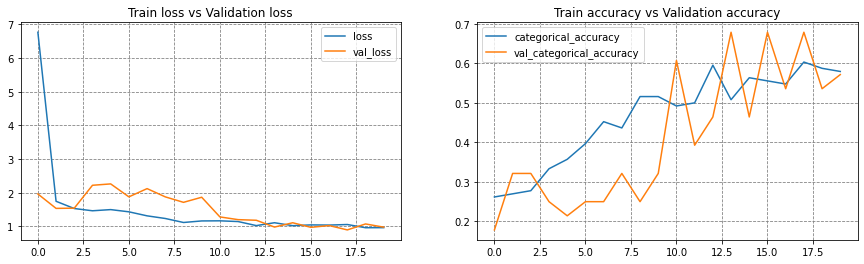

In [482]:
plot(model7_history)

In [ ]:
# Creating Base model8

model8 = Sequential()

model8.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(30,120,120,3), padding='same'))
model8.add(BatchNormalization())
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2,2,2)))

model8.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model8.add(BatchNormalization())
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2,2,2)))

model8.add(Conv3D(32, kernel_size=(3,2,2), padding='same'))
model8.add(BatchNormalization())
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2,2,2)))

model8.add(Conv3D(64, kernel_size=(3,2,2), padding='same'))
model8.add(BatchNormalization())
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten Layers
model8.add(Flatten())

model8.add(Dense(1024, activation='relu'))
model8.add(Dropout(0.5))

model8.add(Dense(512, activation='relu'))
model8.add(Dropout(0.5))

# Softmax layer
model8.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.optimizers.Adam()
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_171 (Conv3D)         (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_168 (Ba  (None, 30, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 activation_144 (Activation)  (None, 30, 120, 120, 8)  0         
                                                                 
 max_pooling3d_154 (MaxPooli  (None, 15, 60, 60, 8)    0         
 ng3D)                                                           
                                                                 
 conv3d_172 (Conv3D)         (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_169 (Ba  (None, 15, 60, 60, 16) 

In [ ]:
model8_history = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 7.9516 - categorical_accuracy: 0.1825
Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-7.95160-0.18254-1.71696-0.21429.h5
42/42 [==============================] - 19s 438ms/step - loss: 7.9516 - categorical_accuracy: 0.1825 - val_loss: 1.7170 - val_categorical_accuracy: 0.2143 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.8314 - categorical_accuracy: 0.2540
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-1.83138-0.25397-1.67886-0.14286.h5
42/42 [==============================] - 18s 445ms/step - loss: 1.8314 - categorical_accuracy: 0.2540 - val_loss: 1.6789 - val_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 1.4635 - categorical_accuracy: 0.3413
Epoch 3: saving model to model_init_2022-08-2020_53_34.382864/model-00003-1.46345-0.34127-1.73271-0.25000.h5
42/42 [==========

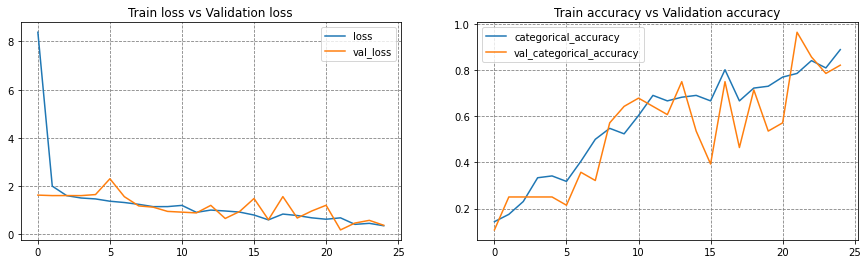

In [483]:
plot(model8_history)

**- Below are the results coming from above models which seems good accuracy:**

- Model: **Conv3D**
- Training Accuracy: **88**
- Validation Accuracy: **82**

# **CNN LSTM with GRU:**

In [451]:
# Model 9

model9 = Sequential()

mobile_net_1 = keras.applications.mobilenet.MobileNet(include_top = False, weights='imagenet',input_shape=(120, 120, 3))

model9.add(TimeDistributed(mobile_net_1, input_shape = (30,120,120,3)))
model9.add(TimeDistributed(Flatten()))
model9.add(GRU(512, activation='relu',return_sequences=False))

model9.add(Dense(512))
model9.add(BatchNormalization())
model9.add(Activation("relu"))

model9.add(Dropout(0.5))
model9.add(Dense(5, activation = 'softmax'))


In [452]:
learning_rate = 0.001
optimiser = tf.optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.8, nesterov=True)
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_205 (TimeD  (None, 30, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_206 (TimeD  (None, 30, 9216)         0         
 istributed)                                                     
                                                                 
 gru_3 (GRU)                 (None, 512)               14945280  
                                                                 
 dense_156 (Dense)           (None, 512)               262656    
                                                                 
 batch_normalization_248 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                     

In [453]:
model9_history = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.9497 - categorical_accuracy: 0.3333
Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-1.94973-0.33333-2.73644-0.39286.h5
42/42 [==============================] - 25s 496ms/step - loss: 1.9497 - categorical_accuracy: 0.3333 - val_loss: 2.7364 - val_categorical_accuracy: 0.3929 - lr: 0.0010
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.8298 - categorical_accuracy: 0.3810
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-1.82983-0.38095-1.68225-0.57143.h5
42/42 [==============================] - 20s 475ms/step - loss: 1.8298 - categorical_accuracy: 0.3810 - val_loss: 1.6822 - val_categorical_accuracy: 0.5714 - lr: 0.0010
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 1.5969 - categorical_accuracy: 0.3968
Epoch 3: saving model to model_init_2022-08-2020_53_34.382864/model-00003-1.59692-0.39683-1.99710-0.46429.h5
42/42 [==========

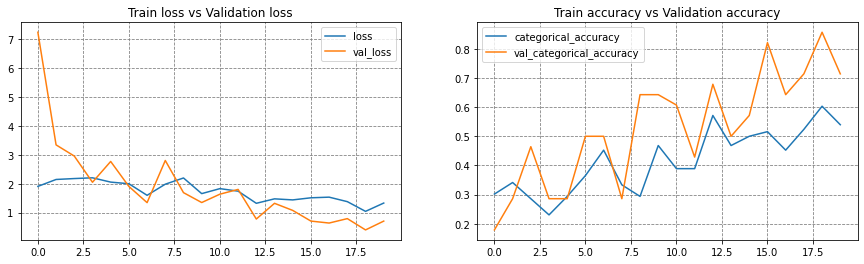

In [485]:
plot(model9_history)

In [467]:
# Model 10

model10 = Sequential()

mobile_net_1 = keras.applications.mobilenet.MobileNet(include_top = False, weights='imagenet',input_shape=(120, 120, 3))

model10.add(TimeDistributed(mobile_net_1, input_shape = (30,120,120,3)))
model10.add(TimeDistributed(Flatten()))
model10.add(GRU(512, activation='relu',return_sequences=False))

model10.add(Dense(512))
model10.add(BatchNormalization())
model10.add(Activation("relu"))

model10.add(Dropout(0.5))
model10.add(Dense(5, activation = 'softmax'))

In [469]:
optimiser = tf.optimizers.Adam(lr=0.001)
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model10.summary())

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_213 (TimeD  (None, 30, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_214 (TimeD  (None, 30, 9216)         0         
 istributed)                                                     
                                                                 
 gru_5 (GRU)                 (None, 512)               14945280  
                                                                 
 dense_164 (Dense)           (None, 512)               262656    
                                                                 
 batch_normalization_252 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                     

In [470]:
model10_history = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.8102 - categorical_accuracy: 0.3413
Epoch 1: saving model to model_init_2022-08-2020_53_34.382864/model-00001-1.81019-0.34127-11.31169-0.50000.h5
42/42 [==============================] - 24s 492ms/step - loss: 1.8102 - categorical_accuracy: 0.3413 - val_loss: 11.3117 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.8420 - categorical_accuracy: 0.3730
Epoch 2: saving model to model_init_2022-08-2020_53_34.382864/model-00002-1.84197-0.37302-3.10662-0.46429.h5
42/42 [==============================] - 20s 490ms/step - loss: 1.8420 - categorical_accuracy: 0.3730 - val_loss: 3.1066 - val_categorical_accuracy: 0.4643 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 1.7472 - categorical_accuracy: 0.3413
Epoch 3: saving model to model_init_2022-08-2020_53_34.382864/model-00003-1.74723-0.34127-5.39863-0.21429.h5
42/42 [========

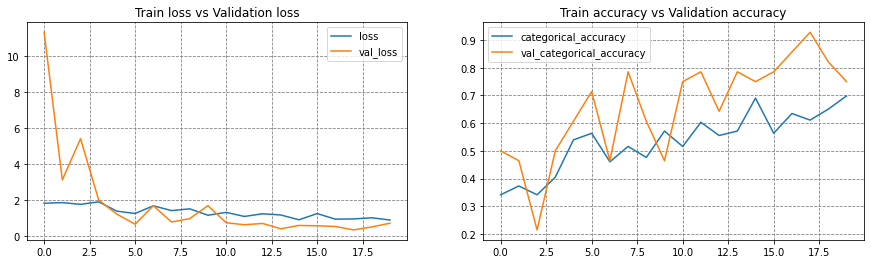

In [484]:
plot(model10_history)

#### From the above experiments, we finalized Model 8 which performed well.

- (Training Accuracy : 88%, Validation Accuracy : 82%)

- Total params: 3,790,437
- Trainable params: 3,790,197
- Non-trainable params: 240